In [179]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold, KFold
from sklearn.impute import KNNImputer
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.model_selection import KFold, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor, plot_tree
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, mean_squared_error, confusion_matrix, precision_score, recall_score, roc_auc_score, roc_curve
# from yellowbrick.target import ClassBalance
from imblearn.under_sampling import RandomUnderSampler
import seaborn as sns
import itertools
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.preprocessing import OrdinalEncoder
# explicitly require this experimental feature
from sklearn.experimental import enable_iterative_imputer  # noqa
from sklearn.impute import IterativeImputer
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
plt.style.use('ggplot')

In [6]:
# Load the data and create a copy to use to verify preprocessing steps
quicken_df = pd.read_csv('data/quicken_2019.csv')
check_df = quicken_df.copy()
# Pull Census Tract dictionary from different notebook
%store -r FIPS_dict

# Step 1: Condense High Cardinality Variables
Action Taken: 
* 1: Loan originated
* 2: Application approved but not accepted
* 3: Application denied
* 4: Application withdrawn by applicant
* 5: File closed for incompleteness
* 6: Purchased loan
* 7: Preapproval request denied
* 8: Preapproval request approved but not accepted

Interpreting which actions are 'approved:' 
1, 2, 6

Denied:
3

Irrelevant to model: 4, 5, 7, 8

-------
* Race and Ethnicity columns both allow the applicant to report a more specific value. For example, an applicant can select Asian (2) or more specifically Chinese(22), etc. Because this column will be onehotencoded, I'm going to simplify these columns to the top-level categories:
    - American Indian or Alaska Native
    - Asian
    - Black or African American
    - Native Hawaiian or Other Pacific Islander
    - White
    - Hispanic
    - Non-Hispanic
------------

Census Tract
* The Census Tract column contains ~65K unique values, 366 of which are NA. These were mapped to 10 'primary codes' which indicate if a region is rural, urban, metropolitan, etc. However, because I couldn't use the mapper dictionary if null values were present, dropped these in this preprocessing step rather than in the general missing values section, below. 

In [7]:
# action taken
quicken_df = quicken_df[~quicken_df['action_taken'].isin([4,5,7,8])]
quicken_df['action_taken'] = quicken_df['action_taken'].map(lambda x: 0 if x ==3 else 1)

# applicant race 
def condense_race(x): 
    if x == 6 or x == 7:
        x = np.nan
    if x> 10 and x < 20: 
        x = 1
    if x> 20 and x < 30: 
        x = 2
    if x> 40 and x < 50: 
        x = 4
    else: 
        x = x
    return x

# applicant ethnicity
def condense_ethnicity(x): 
    if x == 3 or x == 4: 
        x = np.nan
    if x !=2: 
        x = 1
    else: 
        x = x
    return x 

def condense_sex(x): 
    if x == 3 or x == 4: 
        x = np.nan
    else: 
        x = x
    return x 

In [8]:
quicken_df['applicant_race-1'] = quicken_df['applicant_race-1'].apply(lambda x: condense_race(x))
quicken_df['applicant_ethnicity-1'] = quicken_df['applicant_ethnicity-1'].apply(lambda x: condense_ethnicity(x))
quicken_df['applicant_sex'] = quicken_df['applicant_sex'].apply(lambda x: condense_sex(x))

quicken_df = quicken_df.dropna(subset=['census_tract'])
quicken_df['census_tract'] = quicken_df['census_tract'].astype(int)
quicken_df['census_tract'] = quicken_df['census_tract'].astype(str)
quicken_df['census_tract'] = quicken_df['census_tract'].map(FIPS_dict)

# Step 2: Feature Engineering
* Planned to add the following columns: 
    - has co-signer
    - bi/multi-racial
    - co-signer bi/multi-racial
    
However, FFEIC updated their datasets with new "derived" variables, which already achieve this goal for race, ethnicity, and sex. These values don't add up to the original field. Will use both for now. 

* Ordinal Encoding for Age column
* DIR contains str and int, mapped using dictionary

In [9]:
# Create ordinalencoder object
enc = OrdinalEncoder()

# Convert column to array
age_df = quicken_df[['applicant_age']].to_numpy()
enc.fit(age_df)
enc.categories_

# fitted encoder to array
enc_age_arr = enc.transform(quicken_df[['applicant_age']].to_numpy())

# Apply encoder transformation
quicken_df['applicant_age'] = enc_age_arr

In [10]:
DIR_mapper = {'20%-<30%': 25, '30%-<36%': 33, '>60%': 65, '<20%': 15, '50%-60%': 55}


quicken_df['debt_to_income_ratio'] = quicken_df['debt_to_income_ratio'] \
                                    .map(lambda x: DIR_mapper[x] if x in DIR_mapper else int(x), na_action='ignore')

# Step 4: Feature Selection
1. Drop columns containing only one unique value
Null values are represented differently for each variable in the dataset. Looked at each variable and recoded null values to 99 where applicable
2. Check for perfect predictors and drop those
3. Drop certain columns based on what information is relevant. This will apply to all lenders
    a. ```state_code``` and ```county_code``` - using census tract and ```derived_msa-md``` because they are more informative
4. ```Income``` converted na back to np.nan and will impute median for this column
5. There are several census features that were appended to the dataset after the lender submitted their report. While these features might be used in a different part of this study, they will be excluded from the dataset that will be fed into the model, as the bank did not report these values. 
6. Exclude 2nd lien mortgage, interest only payment loans (only ~400 of these loans)

In [ ]:
perfect_predictors = []
for col in quicken_df.columns: 
    cross = pd.crosstab(quicken_df[col], quicken_df['action_taken'])
    if cross[0].sum() == 0 or cross[1].sum() == 0:
        perfect_predictors.append(col)
perfect_predictors

In [11]:
one_unique_value_lst = []
for col in quicken_df.columns:
    if len(quicken_df[col].unique()) ==1: 
        one_unique_value_lst.append(col)
quicken_df = quicken_df.drop(one_unique_value_lst, axis=1)

In [12]:
# null coded as 99999, 0, 5 --> recode to 99
quicken_df['derived_msa-md'] = quicken_df['derived_msa-md'].apply(lambda x: 99 if x == 99999 else x)
quicken_df['purchaser_type'] = quicken_df['purchaser_type'].apply(lambda x: 99 if x == 0 else x)
quicken_df['loan_purpose'] = quicken_df['loan_purpose'].apply(lambda x: 99 if x == 5 else x)
quicken_df['applicant_credit_score_type'] = quicken_df['applicant_credit_score_type'] \
                                                    .apply(lambda x: 99 if x == 9 else x)
quicken_df['applicant_ethnicity_observed'] = quicken_df['applicant_ethnicity_observed'] \
                                                    .apply(lambda x: 99 if x == 3 else x)
quicken_df['applicant_race_observed'] = quicken_df['applicant_race_observed'] \
                                                    .apply(lambda x: 99 if x == 3 else x)
quicken_df['submission_of_application'] = quicken_df['submission_of_application'] \
                                                    .apply(lambda x: 99 if x == 3 else x)

In [13]:
# Columns to drop b/c irrelevant or class imbalance is extreme 
drop_irrelevant = ['state_code', 'county_code', 'open-end_line_of_credit', 'manufactured_home_land_property_interest', 
                  'manufactured_home_secured_property_type', 'co-applicant_credit_score_type', 'applicant_ethnicity-2',
                  'applicant_ethnicity-3', 'applicant_ethnicity-4', 'co-applicant_ethnicity-1', 'co-applicant_ethnicity-2',
                  'co-applicant_ethnicity-3', 'co-applicant_ethnicity-4', 'co-applicant_ethnicity_observed',
                  'applicant_race-2', 'applicant_race-3', 'applicant_race-4', 'applicant_race-5', 
                  'co-applicant_race-1', 'co-applicant_race-2', 'co-applicant_race-3', 'co-applicant_race-4', 
                  'co-applicant_race-5', 'co-applicant_race_observed', 'co-applicant_sex', 'applicant_sex_observed',
                  'co-applicant_sex_observed', 'co-applicant_age', 'applicant_age_above_62', 'co-applicant_age_above_62',
                  'submission_of_application', 'derived_loan_product_type', 'interest_only_payment', 'applicant_ethnicity-1',
                  'applicant_race-1', 'applicant_sex', 'derived_msa-md']

confirmed_perfect_pred = ['denial_reason-1', 'denial_reason-2', 'denial_reason-3', 'purchaser_type', 'preapproval', 
                       'interest_rate', 'rate_spread', 'hoepa_status', 'total_loan_costs', 'origination_charges', 
                       'discount_points', 'lender_credits', 'initially_payable_to_institution']

census_appended = ['tract_minority_population_percent', 'tract_population', 'ffiec_msa_md_median_family_income',
                  'tract_to_msa_income_percentage', 'tract_owner_occupied_units', 'tract_one_to_four_family_homes',
                  'tract_median_age_of_housing_units']



In [14]:
quicken_df = quicken_df.drop(drop_irrelevant + confirmed_perfect_pred + census_appended, axis=1)

In [15]:
# Subselections of relevant variables
quicken_df = quicken_df[quicken_df['lien_status'] == 1]
quicken_df = quicken_df[quicken_df['loan_purpose'] == 1]


In [16]:
# Drop columns that were subselected to contain only one value
quicken_df = quicken_df.drop(['lien_status', 'loan_purpose'], axis=1)

# Step 3: Missing Values
1. Some variables are perfect predictors when they are null. Filled all nan values with 99 so I could run a crosstabulation to check for this. 

In [ ]:
quicken_df = quicken_df.fillna(99)

In [17]:
# Recode 99 back to np.nan to further impute values
quicken_df = quicken_df.applymap(lambda x: np.nan if x == 99 else x)

In [18]:
# Impute median for nan in the following columns
quicken_df['debt_to_income_ratio'] = quicken_df['debt_to_income_ratio'].fillna(quicken_df['debt_to_income_ratio'] \
                                                                               .median())
quicken_df['income'] = quicken_df['income'].fillna(quicken_df['income'].median())
quicken_df['property_value'] = quicken_df['property_value'].fillna(quicken_df['property_value'].median())
quicken_df['income'] = quicken_df['income'].fillna(quicken_df['income'].median())
quicken_df['loan_to_value_ratio'] = quicken_df['loan_to_value_ratio'].fillna(quicken_df['loan_to_value_ratio'] \
                                                                             .median())

In [19]:
# If the percentage of NON null values is under 5% of the entire dataset, drop column
mostly_null = []
for col in quicken_df.columns: 
    if quicken_df[col].notnull().sum()/quicken_df.shape[0] * 100 <5:
        mostly_null.append(col)
quicken_df = quicken_df.drop(mostly_null, axis=1)

In [20]:
# create list of columns that have null values that need to be handled
has_nulls = []
for col in quicken_df.columns: 
    if quicken_df[col].notnull().sum() != quicken_df.shape[0]: 
        has_nulls.append(col)
has_nulls

['census_tract',
 'applicant_credit_score_type',
 'applicant_ethnicity_observed',
 'applicant_race_observed']

In [18]:
# If the percentage of NON null values is under 5% of the entire dataset, drop column
for col in quicken_df.columns: 
    if quicken_df[col].notnull().sum()/quicken_df.shape[0] * 100 < 5:
        mostly_null.append(col)

In [19]:
# Calculate missing value ratio for remaining columns with null value
missing_val_dict = {}
for col in has_nulls: 
    missing_val_dict[col] = quicken_df[col].isnull().sum()/quicken_df.shape[0]* 100
missing_val_dict

{'derived_msa-md': 14.53216758824572,
 'census_tract': 19.61733979105792,
 'applicant_credit_score_type': 0.6484409398390906,
 'applicant_ethnicity_observed': 0.6461536702100286,
 'applicant_race_observed': 0.6461536702100286}

In [20]:
census_tract_df = pd.DataFrame(quicken_df['census_tract'].value_counts()).reset_index()

In [21]:
census_tract_df = census_tract_df.sort_values('index')
census_tract_df['pop_percent'] = census_tract_df['census_tract']/census_tract_df['census_tract'].sum() * 100

In [22]:
quicken_df.shape

(174881, 23)

<BarContainer object of 10 artists>

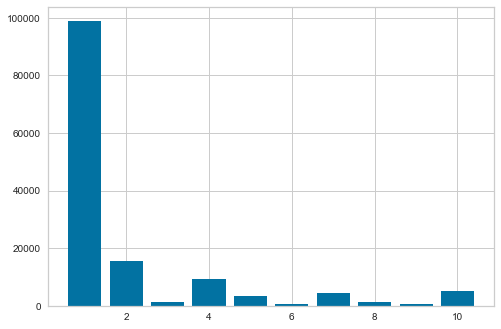

In [23]:
fig, ax = plt.subplots()
ax.bar(census_tract_df['index'], census_tract_df['census_tract'])

In [ ]:
quicken_df['derived_race'].value_counts(dropna=False)

# Check to see if values are missing at random
* Variables that might be different "enough" based on the mean:
    * property value
    * loan amount
* However, std is very similar, so I'll assume values are missing at random 

In [ ]:
# fig, ax = plt.subplots()

census_missing = quicken_df[quicken_df['census_tract'].isnull()]
census_missing.describe().reset_index().iloc[[1]]

In [ ]:
quicken_df.describe().reset_index().iloc[[1]]

In [ ]:
quicken_df['derived_msa-md'].value_counts()

In [21]:
## To get a MVP, dropped null census values. I may go back and use multivariate imputation later. 

quicken_df = quicken_df.dropna(subset=['census_tract',  'applicant_credit_score_type', 'applicant_ethnicity_observed', 
                                        'applicant_race_observed'])

## Using multivariate imputation for remaining missing values

In [ ]:
# imputer = IterativeImputer(random_state=0)
# quicken_filled = imputer.fit_transform(quicken_df)

# Examine Class Imbalance


In [ ]:
boa_df['action_taken'].value_counts()

# Examing Colinearity

# Check for Perfect Predictors

# Preparing Data for Model
* One hot encoding
* Feature/target
* train_test_split

In [22]:
# feature (X) and target(y) matrices, will encode on X instead of entire dataframe
X = quicken_df.drop(['action_taken'], axis=1)
y = quicken_df['action_taken']

### Identifying categorical columns

In [ ]:
quicken_df[quicken_df.columns[18]].value_counts(dropna=False)

In [45]:
quicken_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 139533 entries, 23 to 774899
Data columns (total 22 columns):
 #   Column                        Non-Null Count   Dtype  
---  ------                        --------------   -----  
 0   census_tract                  139533 non-null  float64
 1   conforming_loan_limit         139533 non-null  object 
 2   derived_dwelling_category     139533 non-null  object 
 3   derived_ethnicity             139533 non-null  object 
 4   derived_race                  139533 non-null  object 
 5   derived_sex                   139533 non-null  object 
 6   action_taken                  139533 non-null  int64  
 7   loan_type                     139533 non-null  int64  
 8   loan_amount                   139533 non-null  float64
 9   loan_to_value_ratio           139533 non-null  float64
 10  loan_term                     139533 non-null  int64  
 11  property_value                139533 non-null  float64
 12  construction_method           139533 non-nu

In [23]:
# loan_type_2, aus-1_6
categorical_cols = ['census_tract', 'conforming_loan_limit', 'derived_dwelling_category', 'derived_ethnicity', 
                      'derived_race', 'derived_sex', 'loan_type', 'construction_method', 'occupancy_type', 
                      'applicant_credit_score_type', 'applicant_ethnicity_observed', 'applicant_race_observed', 
                      'aus-1']

In [24]:
# Use one-hot encoding for categorical columns
X = pd.get_dummies(X, columns = categorical_cols)

In [25]:
# Drop columns that are duplicates of a binary dummy variable
dummies_to_drop = ['aus-1_3', 'occupancy_type_2', 'aus-1_3', 'applicant_race_observed_2.0', 'applicant_ethnicity_observed_2.0', 'derived_sex_Female', 
                   'conforming_loan_limit_NC', 'construction_method_2', 
                   'derived_dwelling_category_Single Family (1-4 Units):Manufactured', ]
X = X.drop(dummies_to_drop, axis=1)

In [26]:
X.head()

,loan_amount,loan_to_value_ratio,loan_term,property_value,total_units,income,debt_to_income_ratio,applicant_age,census_tract_1.0,census_tract_2.0,census_tract_3.0,census_tract_4.0,census_tract_5.0,census_tract_6.0,census_tract_7.0,census_tract_8.0,census_tract_9.0,census_tract_10.0,conforming_loan_limit_C,derived_dwelling_category_Single Family (1-4 Units):Site-Built,derived_ethnicity_Ethnicity Not Available,derived_ethnicity_Hispanic or Latino,derived_ethnicity_Joint,derived_ethnicity_Not Hispanic or Latino,derived_race_2 or more minority races,derived_race_American Indian or Alaska Native,derived_race_Asian,derived_race_Black or African American,derived_race_Joint,derived_race_Native Hawaiian or Other Pacific Islander,derived_race_Race Not Available,derived_race_White,derived_sex_Joint,derived_sex_Male,derived_sex_Sex Not Available,loan_type_1,loan_type_2,loan_type_3,loan_type_4,construction_method_1,occupancy_type_1,occupancy_type_3,applicant_credit_score_type_1.0,applicant_credit_score_type_2.0,applicant_credit_score_type_3.0,applicant_ethnicity_observed_1.0,applicant_race_observed_1.0,aus-1_1,aus-1_2,aus-1_4,aus-1_6
23,155000.0,98.63,360,155000.0,1,104.0,45.0,4.0,0,0,0,0,0,0,1,0,0,0,1,1,0,0,0,1,0,0,0,0,0,0,0,1,1,0,0,0,0,1,0,1,1,0,1,0,0,0,0,1,0,0,0
26,75000.0,75.00,360,105000.0,1,79.0,65.0,1.0,0,0,0,0,0,0,0,0,0,1,1,1,0,0,0,1,0,0,0,0,0,0,0,1,1,0,0,0,1,0,0,1,1,0,0,0,1,0,0,0,0,0,0
30,215000.0,100.00,360,215000.0,1,74.0,39.0,2.0,0,0,0,0,1,0,0,0,0,0,1,1,0,0,0,1,0,0,0,0,0,0,0,1,0,1,0,0,0,1,0,1,1,0,0,0,1,0,0,1,0,0,0
33,185000.0,95.00,360,195000.0,1,90.0,43.0,4.0,1,0,0,0,0,0,0,0,0,0,1,1,0,0,1,0,0,0,0,0,0,0,0,1,1,0,0,1,0,0,0,1,1,0,1,0,0,0,0,1,0,0,0
38,45000.0,97.00,360,45000.0,1,31.0,33.0,1.0,0,0,0,0,0,0,1,0,0,0,1,1,0,0,0,1,0,0,0,0,0,0,0,1,0,1,0,1,0,0,0,1,1,0,0,1,0,0,0,0,1,0,0


## Check for colinear variables

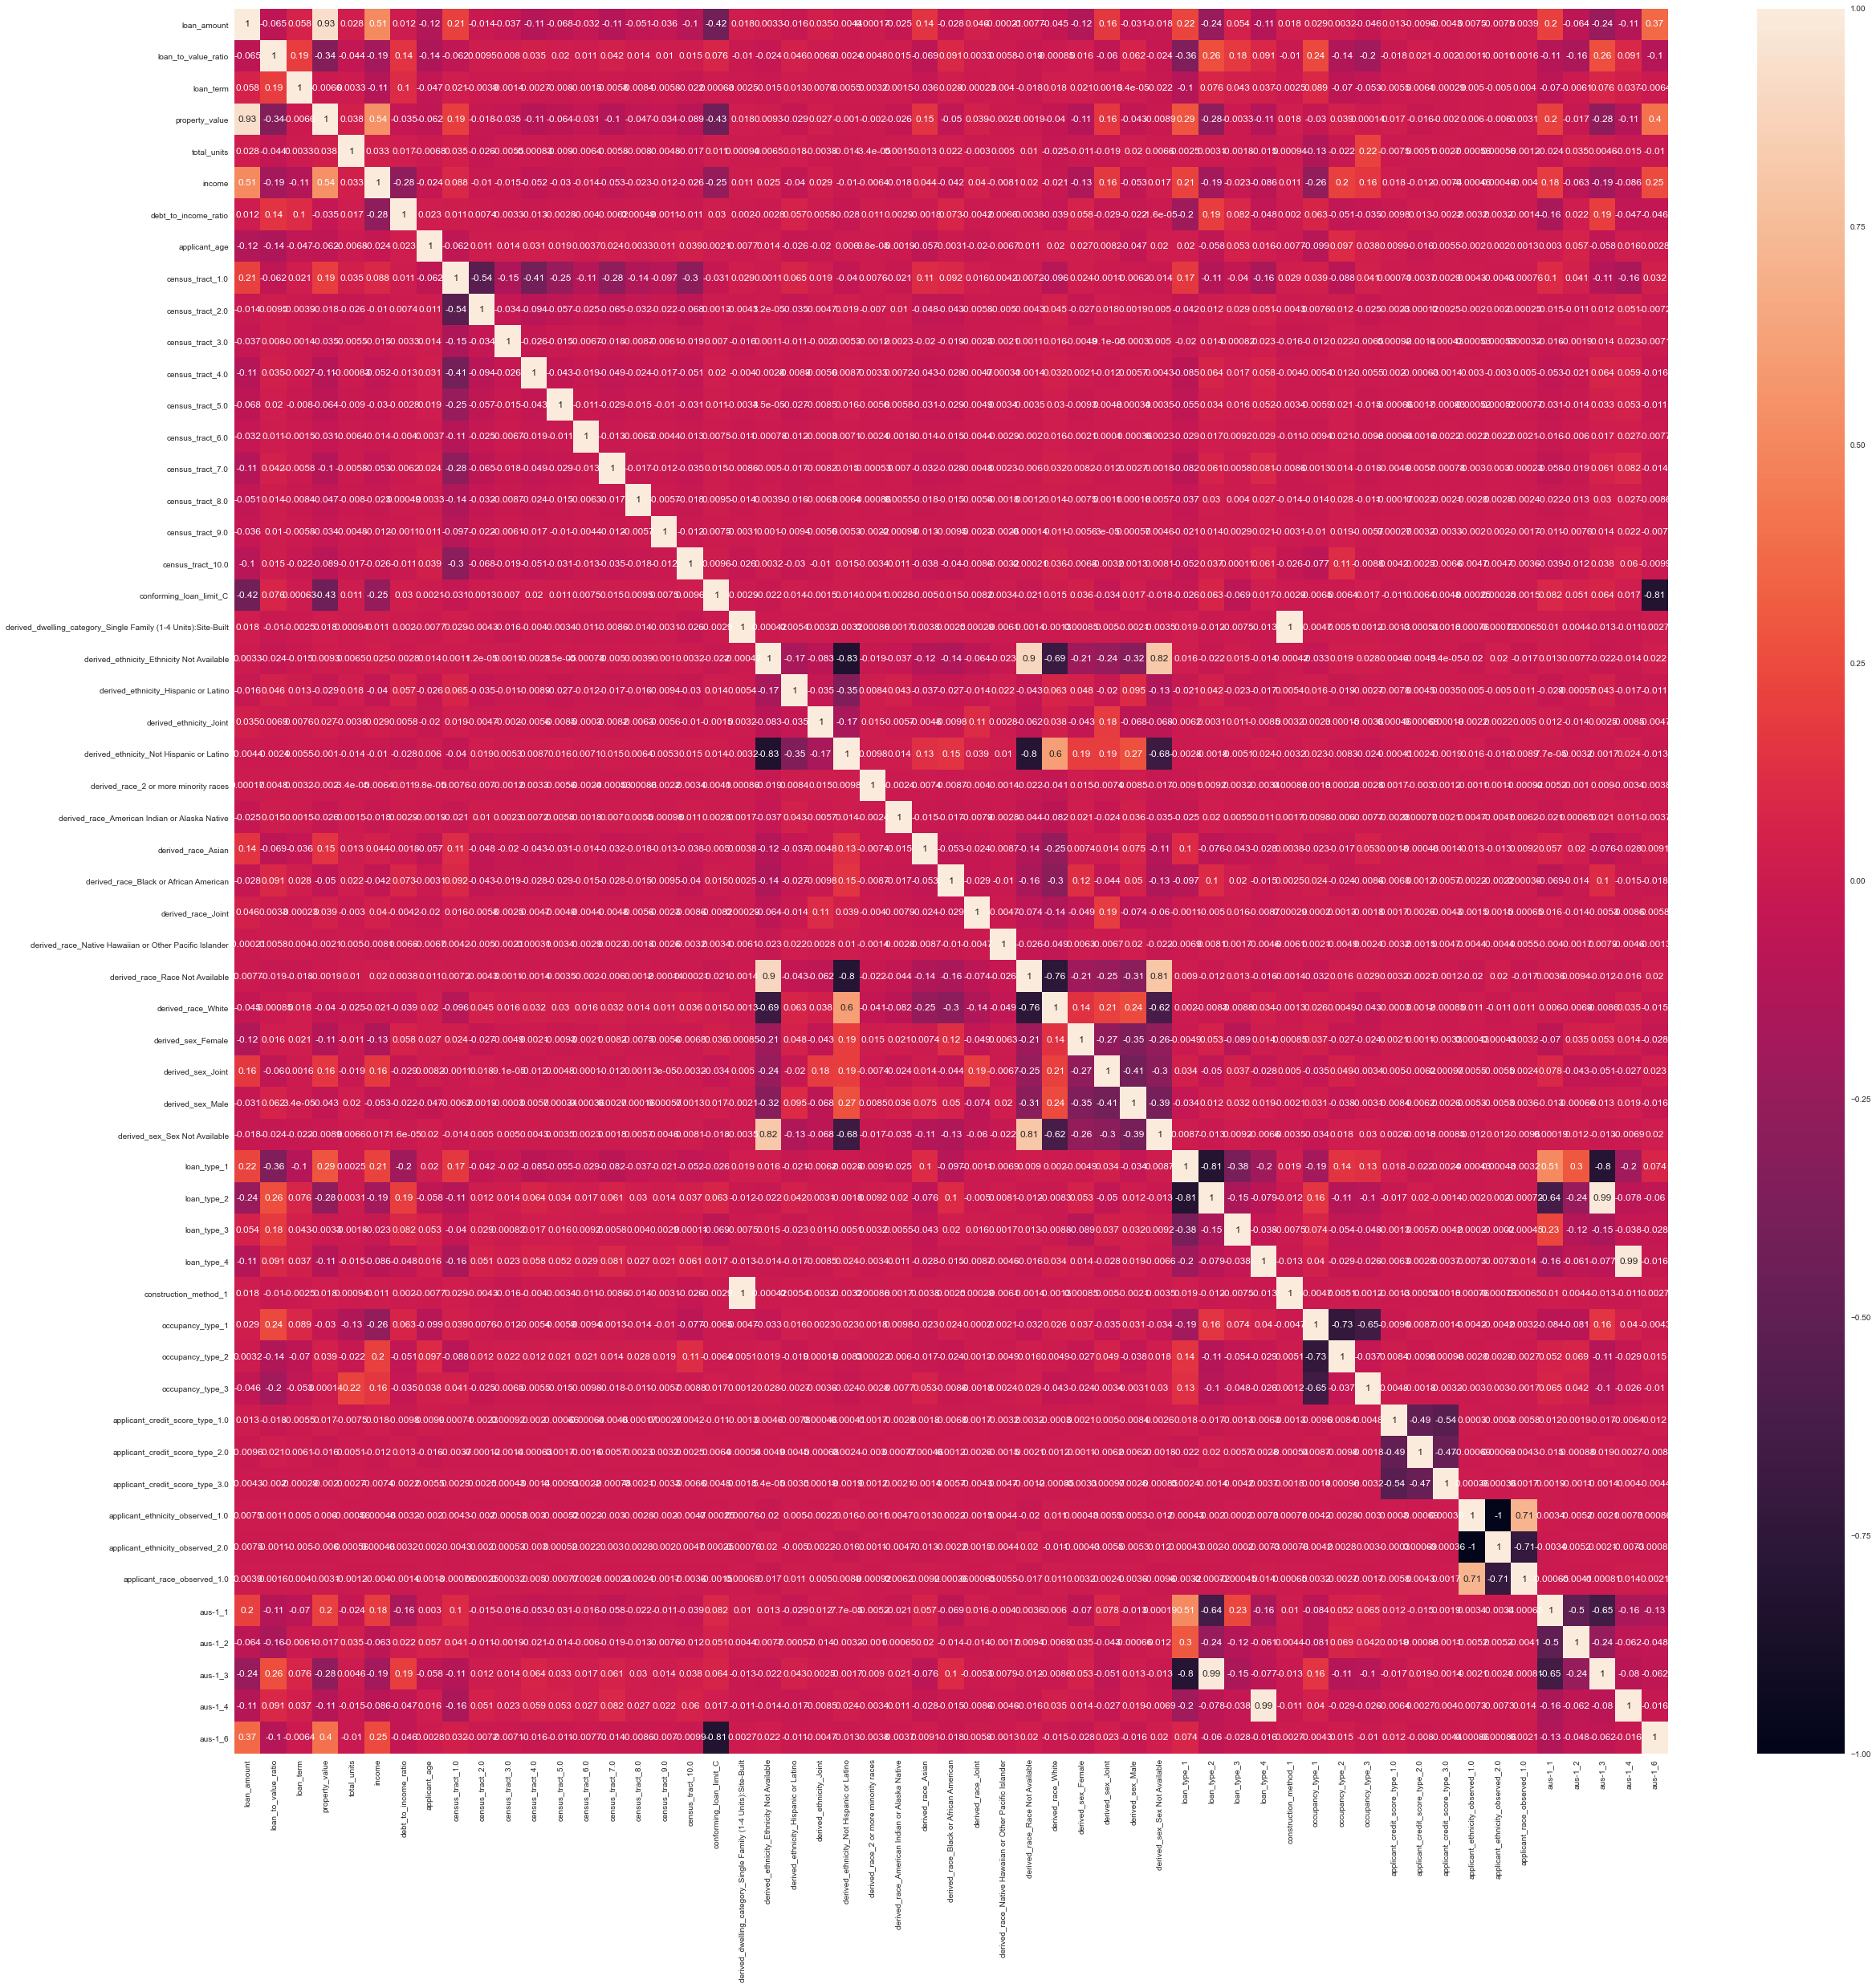

In [95]:
corr = X.corr()
plt.figure(figsize=(40,40))
sns.heatmap(cor, annot=True)
plt.savefig('corr_matrix_4');

In [96]:
corr_pairs = corr.unstack()
sorted_pairs = corr_pairs.sort_values(kind="quicksort")

strong_pairs = sorted_pairs[abs(sorted_pairs) > 0.5]
pd.DataFrame(strong_pairs)

0
derived_ethnicity_Not Hispanic or Latino           derived_ethnicity_Ethnicity Not Available          -0.829133
derived_ethnicity_Ethnicity Not Available          derived_ethnicity_Not Hispanic or Latino           -0.829133
conforming_loan_limit_C                            aus-1_6                                            -0.812756
aus-1_6                                            conforming_loan_limit_C                            -0.812756
loan_type_1                                        loan_type_2                                        -0.807766
loan_type_2                                        loan_type_1                                        -0.807766
derived_ethnicity_Not Hispanic or Latino           derived_race_Race Not Available                    -0.801990
derived_race_Race Not Available                    derived_ethnicity_Not Hispanic or Latino           -0.801990
                                                   derived_race_White                                 -0.763355
derived_race_White                                 derived_race_Race Not Available                    -0.763355
derived_ethnicity_Ethnicity Not Available          derived_race_White                                 -0.689832
derived_race_White                                 derived_ethnicity_Ethnicity Not Available          -0.689832
derived_sex_Sex Not Available                      derived_ethnicity_Not Hispanic or Latino           -0.679288
derived_ethnicity_Not Hispanic or Latino           derived_sex_Sex Not Available                      -0.679288
occupancy_type_1                                   occupancy_type_3                                   -0.652032
occupancy_type_3                                   occupancy_type_1                                   -0.652032
loan_type_2                                        aus-1_1                                            -0.640437
aus-1_1                                            loan_type_2                                        -0.640437
derived_sex_Sex Not Available                      derived_race_White                                 -0.617872
derived_race_White                                 derived_sex_Sex Not Available                      -0.617872
census_tract_1.0                                   census_tract_2.0                                   -0.543369
census_tract_2.0                                   census_tract_1.0                                   -0.543369
applicant_credit_score_type_3.0                    applicant_credit_score_type_1.0                    -0.543082
applicant_credit_score_type_1.0                    applicant_credit_score_type_3.0                    -0.543082
aus-1_2                                            aus-1_1                                            -0.500123
aus-1_1                                            aus-1_2                                            -0.500123
                                                   loan_type_1                                         0.508913
loan_type_1                                        aus-1_1                                             0.508913
income                                             loan_amount                                         0.511722
loan_amount                                        income                                              0.511722
income                                             property_value                                      0.540295
property_value                                     income                                              0.540295
derived_ethnicity_Not Hispanic or Latino           derived_race_White                                  0.604260
derived_race_White                                 derived_ethnicity_Not Hispanic or Latino            0.604260
applicant_ethnicity_observed_1.0                   applicant_race_observed_1.0                         0.712911
applicant_race_observed_1.0                        applicant_ethnicity_observe

### Split data into train, test, holdout

In [27]:
# Create TTS on entire dataset, stratify y to handle class imbalance
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, stratify=y, random_state=42)

# Take subset to train model initially
X_sub = X[::40]
y_sub = y[::40]
X_train_sub, X_test_sub, y_train_sub, y_test_sub = train_test_split(X_sub, y_sub, test_size = 0.20, 
                                                                    shuffle=True, stratify=y_sub)

In [28]:
X_sub.shape

(3489, 51)

# MVP
### Logistic Regression
* Training on entire dataset ~30 minutes, with similar ROC-AUC scores

In [101]:
# 8:34
lr_pipe = Pipeline([('scaler', StandardScaler()), ('classifier', LogisticRegressionCV(solver='liblinear'))])
lr_grid_params = {'classifier__penalty': ['l1', 'l2', 'elasticnet']}
lr_grid = GridSearchCV(lr_pipe, lr_grid_params, cv=StratifiedKFold(10, shuffle=True), scoring = 'f1')
fitted = lr_grid.fit(X_train_sub, y_train_sub)
print(f'Logistic Regression ROC-AUC training subset: { lr_grid.score(X_train_sub, y_train_sub)}')
print(f'Logistic Regression ROC-AUC test subset: { lr_grid.score(X_test_sub, y_test_sub)}')

Logistic Regression Recall training subset: 0.6912937911897329
Logistic Regression Recall full test set: 0.6746042733859431


In [104]:
# Creating a ROC Curve

# predict probabilities
lr_probs = fitted.predict_proba(X_test_sub)

# keep probabilities for the positive outcome only
lr_probs = lr_probs[:, 1]

# calculate scores
lr_auc = roc_auc_score(y_test_sub, lr_probs)

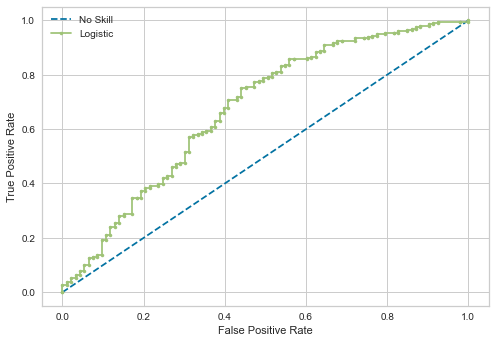

In [106]:
# roc curve for logistic regression model
# calculate roc curves
fpr, tpr, thresholds = roc_curve(y_test_sub, lr_probs)

# plot the roc curve for the model
pyplot.plot([0,1], [0,1], linestyle='--', label='No Skill')
pyplot.plot(fpr, tpr, marker='.', label='Logistic')

# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
pyplot.legend()

# show the plot
pyplot.show()

In [182]:
lr_pipe = Pipeline([('scaler', StandardScaler()), ('classifier', LogisticRegression(solver='saga'))])
lr_grid_params = {'classifier__penalty': ['l1', 'l2', 'elasticnet', 'none']}
lr_grid = GridSearchCV(lr_pipe, lr_grid_params, cv=StratifiedKFold(10, shuffle=True), scoring = 'f1')
fitted = lr_grid.fit(X_train_sub, y_train_sub)
print(f'Logistic Regression ROC-AUC training subset: { lr_grid.score(X_train_sub, y_train_sub)}')
print(f'Logistic Regression ROC-AUC test subset: { lr_grid.score(X_test_sub, y_test_sub)}')


/Users/carlahuebner/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/Users/carlahuebner/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/Users/carlahuebner/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/Users/carlahuebner/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/Users/carlahuebner/opt/anaconda3/lib/python3.7/site-packages/sklearn/li

/Users/carlahuebner/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/Users/carlahuebner/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/Users/carlahuebner/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/Users/carlahuebner/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/Users/carlahuebner/opt/anaconda3/lib/python3.7/site-packages/sklearn/li

Logistic Regression ROC-AUC training subset: 0.9088408644400786
Logistic Regression ROC-AUC test subset: 0.9086614173228347


/Users/carlahuebner/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


In [140]:
accuracy_score(fitted.predict(X_test_sub), y_test_sub)

0.8336314847942755

In [137]:
# create an array of predicted probabilities, keeping only the positive outcomes
lr_probs = fitted.predict_proba(X_test_sub)

# Predicted values based on fitted regression model
lr_pred = fitted.predict(X_test_sub)
np.unique(lr_pred)

array([0, 1])

### Random Forest

In [150]:
rf_pipe = Pipeline([('scaler', StandardScaler()), ('classifier', RandomForestClassifier())])
rf_grid_params = {}
rf_grid = GridSearchCV(rf_pipe, rf_grid_params, cv=StratifiedKFold(10, shuffle=True), scoring = 'f1')
fitted = rf_grid.fit(X_train_sub, y_train_sub) 
print(f'Random Forest ROC-AUC training subset: { fitted.score(X_train_sub, y_train_sub)}')
print(f'Random Forest ROC-AUC test subset: { fitted.score(X_test_sub, y_test_sub)}')

Random Forest ROC-AUC training subset: 1.0
Random Forest ROC-AUC test subset: 0.9244372990353698


In [29]:
## Tuning Random Forest
# Random Forest is overfitting. Increased the num for min_samples_split to 6

rf_pipe2 = Pipeline([('classifier', RandomForestClassifier(max_depth=12, max_features = 6, min_samples_leaf = 60, 
                                                           min_samples_split = 6, n_jobs=-1, n_estimators = 250,
                                                           oob_score=True, random_state=42))])

rf_grid_params2 = {}

rf_grid2 = GridSearchCV(rf_pipe2, rf_grid_params2, cv=StratifiedKFold(10, shuffle=True), scoring = 'f1')
rf_fitted2 = rf_grid2.fit(X_train_sub, y_train_sub) 
print(f'Random Forest ROC-AUC training subset: { rf_grid2.score(X_train_sub, y_train_sub)}')
print(f'Random Forest ROC-AUC test subset: { rf_grid2.score(X_test_sub, y_test_sub)}')

Random Forest ROC-AUC training subset: 0.9072043852779953
Random Forest ROC-AUC test subset: 0.9068128425998434


In [193]:
accuracy_score(rf_fitted2.predict(X_test_sub), y_test_sub)

0.829512893982808

In [30]:
rf_pred = rf_fitted2.predict(X_test_sub)


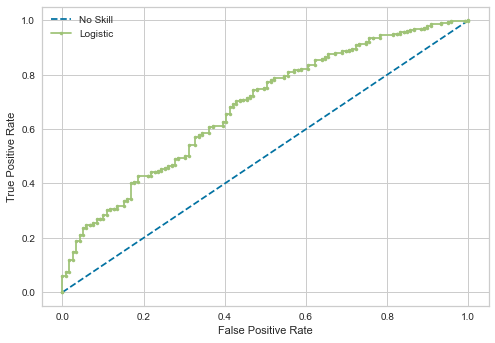

In [175]:
lr_probs = rf_fitted2.predict_proba(X_test_sub)

# keep probabilities for the positive outcome only
lr_probs = lr_probs[:, 1]

# calculate scores
lr_auc = roc_auc_score(y_test_sub, lr_probs)
# roc curve for logistic regression model
# calculate roc curves
fpr, tpr, thresholds = roc_curve(y_test_sub, lr_probs)

# plot the roc curve for the model
pyplot.plot([0,1], [0,1], linestyle='--', label='No Skill')
pyplot.plot(fpr, tpr, marker='.', label='Logistic')

# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
pyplot.legend()

# show the plot
pyplot.show()

In [110]:
tn, fp, fn, tp = confusion_matrix(y_test_sub, rf_pred)

array([[  0, 119],
       [  0, 579]])

In [208]:
(tn, fp, fn, tp)

(0, 119, 0, 579)

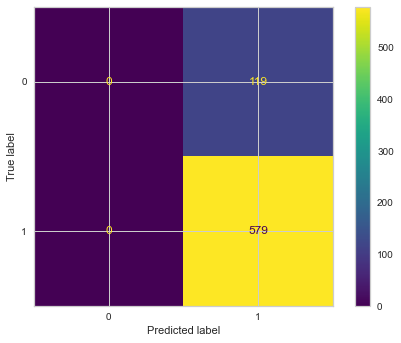

In [210]:
from sklearn.metrics import plot_confusion_matrix
plot_confusion_matrix(rf_fitted2, X_test_sub, y_test_sub)

In [31]:
y.value_counts()

1    116111
0     23422
Name: action_taken, dtype: int64

# Class Imbalance - Random Undersampling
* RUS generated a model that predicts both classes rather than just the positive class. However, the threshold appears to be off, so I've created a profit curve to determine the best threshold to use in this business case. 
* Profit Curve shows that profit levels off at a threshold of ~0.80

In [41]:

undersample = RandomUnderSampler(sampling_strategy=0.7)
# fit and apply the transform
X_under, y_under = undersample.fit_resample(X, y)

X_under.shape

(56882, 51)

In [35]:
X_train_u, X_test_u, y_train_u, y_test_u = train_test_split(X_under, y_under, test_size = 0.20, 
                                                                    shuffle=True)

In [38]:
# Train and evaluate a model using undersampled data
rf_pipe_under = Pipeline([('classifier', RandomForestClassifier(max_depth=12, max_features = 6, min_samples_leaf = 60, 
                                                           min_samples_split = 6, n_jobs=-1, n_estimators = 250,
                                                           oob_score=True, random_state=42))])

rf_grid_params_under = {}

rf_grid_under = GridSearchCV(rf_pipe_under, rf_grid_params_under, 
                             cv=StratifiedKFold(10, shuffle=True), scoring = 'roc_auc')
rf_fitted_under = rf_grid2.fit(X_train_u, y_train_u) 
rf_pred_under = rf_fitted_under.predict(X_test_u)
print(f'Random Forest F1 training subset: { rf_grid2.score(X_train_u, y_train_u)}')
print(f'Random Forest F1 test subset: { rf_grid2.score(X_test_u, y_test_u)}')

Random Forest F1 training subset: 0.7822210819998077
Random Forest F1 test subset: 0.7747909967845659


In [55]:
rf_probs_u = rf_fitted_under.predict_proba(X_test_u)

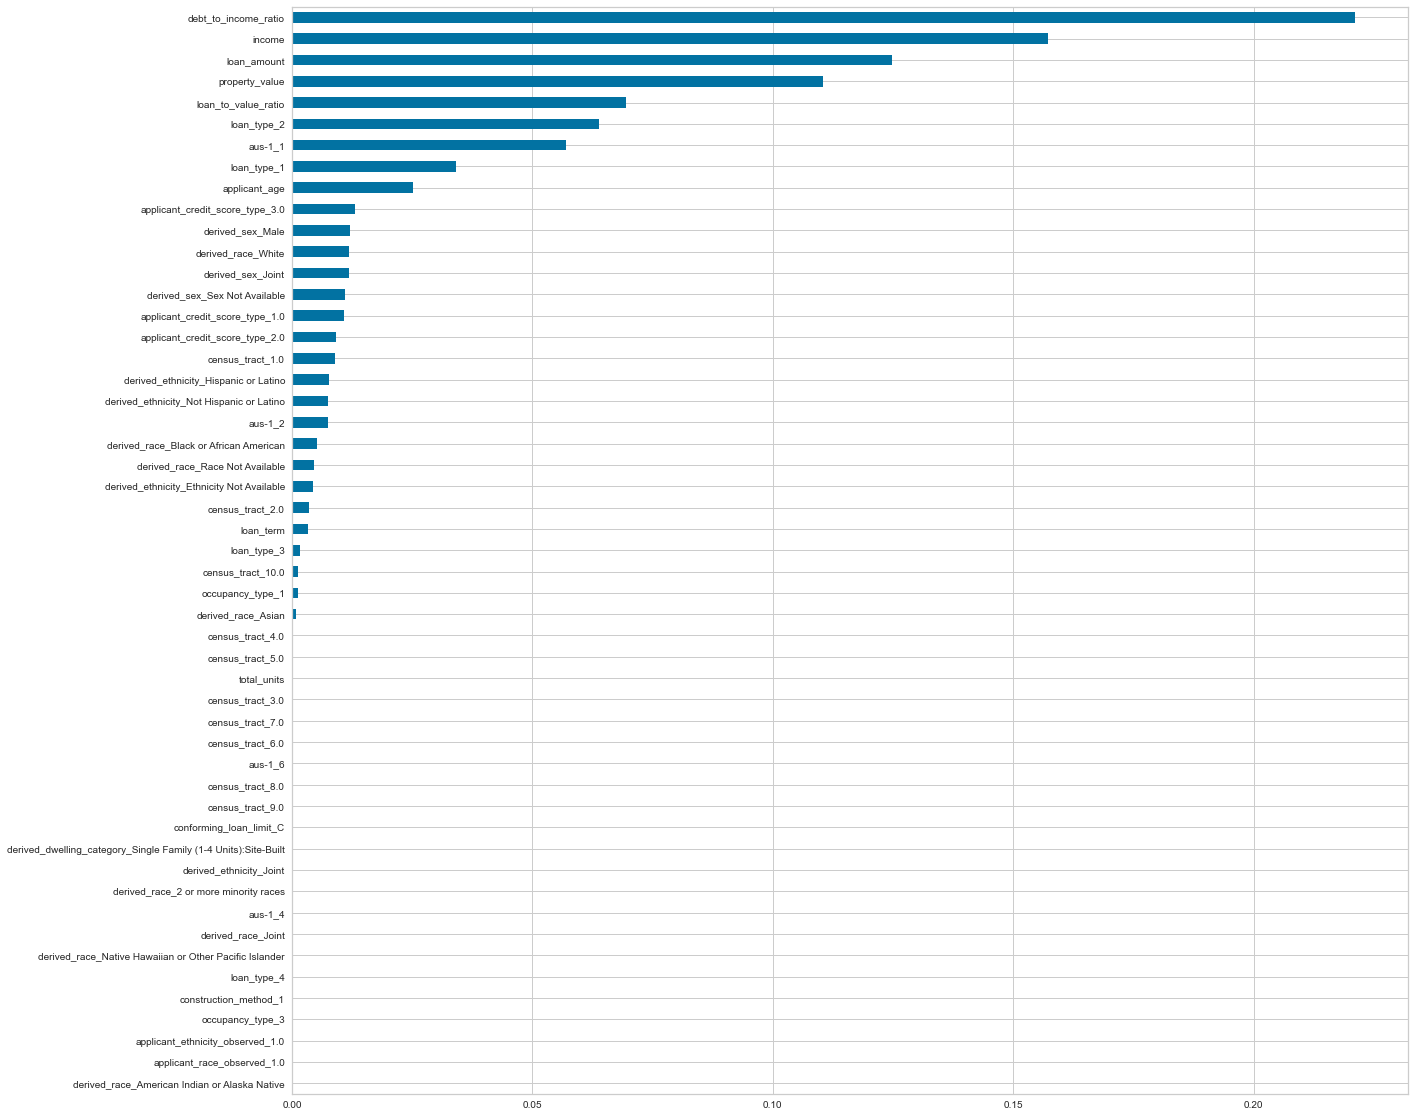

In [188]:
feat_import = rf_fitted2.best_estimator_.named_steps['classifier'].feature_importances_
feature_importance = pd.Series(feat_import, index= X_train_sub.columns)
feature_importance.sort_values(inplace = True)
feature_importance.plot(kind = 'barh', figsize=(20,20))

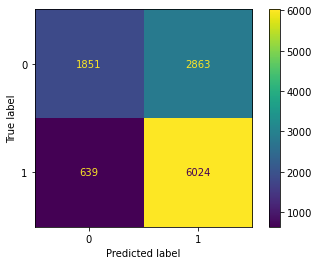

In [39]:
from sklearn.metrics import plot_confusion_matrix
plot_confusion_matrix(rf_fitted_under, X_test_u, y_test_u)

In [48]:
len(rf_pred_under[rf_pred_under == 1])

8887

In [42]:
y_train.shape

(111626,)

In [137]:
from matplotlib import pyplot
rf_probs_u = rf_fitted2.predict_proba(X_test_u)

# keep probabilities for the positive outcome only
rf_probs_u = lr_probs_u[:, 1]

# calculate scores
rf_auc = roc_auc_score(y_test_u, lr_probs_u)
# roc curve for logistic regression model
# calculate roc curves
fpr, tpr, thresholds = roc_curve(y_test_u, rf_probs_u)

# plot the roc curve for the model
pyplot.plot([0,1], [0,1], linestyle='--', label='No Skill')
pyplot.plot(fpr, tpr, marker='.', label='Logistic')

# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
pyplot.legend()

# show the plot
pyplot.show()

IndexError: too many indices for array

In [52]:
accuracy_score(y_test_u, rf_pred_under)

0.6921859892766107

In [159]:
cost_benefit_matrix = np.array([[145, -50],[-145, 0]])
cost_benefit_matrix

array([[ 145,  -50],
       [-145,    0]])

In [116]:
def profit_curve(cost_benefit_matrix, y_prob, y_test):
    """ To calculate list of profits based on supplied cost-benefit
    matrix and predicted probabilities of data points and their true labels.

    Parameters
    ----------
    cost_benefit_matrix    : ndarray - 2D, with profit values corresponding to:
                                          -----------
                                          | TP | FP |
                                          -----------
                                          | FN | TN |
                                          -----------
    y_prob : ndarray - 1D, predicted probability for each data point
                                    in labels, in range [0, 1]
    y_test : ndarray - 1D, true label of data points, 0 or 1

    Returns
    -------
    profits    : ndarray - 1D
    thresholds : ndarray - 1D
    """
    n_obs = float(len(y_test))

  
    thresholds =  sorted(y_prob[:,1], reverse=True)
    profits = []
    y_preds = []
    for threshold in thresholds:

        y_pred = y_prob[:,1] >= threshold
        confusion_mat = confusion_matrix(y_test, y_pred)
        profit = np.sum(cost_benefit_matrix*confusion_mat)/n_obs
        profits.append(profit)
    return np.array(profits), np.array(thresholds)

In [160]:
profits, thresholds = profit_curve(cost_benefit_matrix, rf_probs_u, y_test_u)

In [161]:
prof = np.round(profits, 3)
thresh = np.round(thresholds, 3)

Text(0.5, 1.0, 'Profit at Varying Thresholds for Cost-Benefit Matrix')

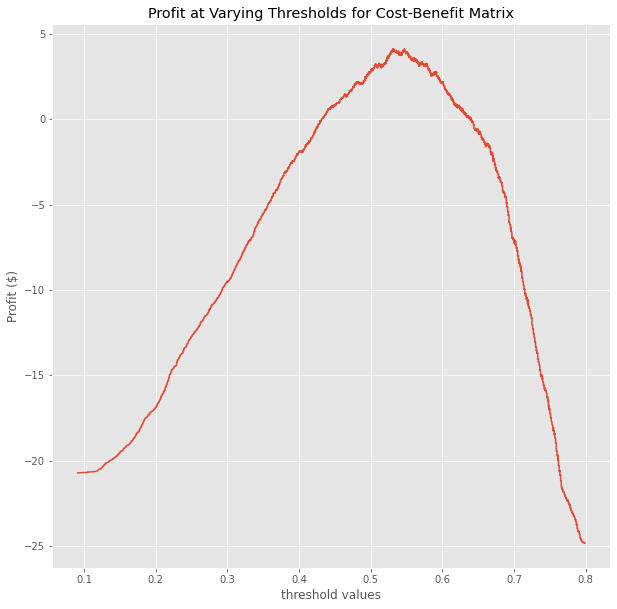

In [162]:
fig, ax = plt.subplots(figsize=(10,10))
ax.plot(thresh, prof)
ax.set_xlabel('threshold values')
ax.set_ylabel('Profit ($)')
ax.set_title('Profit at Varying Thresholds for Cost-Benefit Matrix')

In [145]:
rf_probs = rf_fitted2.predict_proba(X_test_sub)

In [170]:
# Use threshold from Profit Curve to determine classification
final_preds = []
for i in rf_probs_u[:,1]: 
    if i >=0.55: 
        final_preds.append(1)
    else: 
        final_preds.append(0)
        

In [171]:
accuracy_score(y_test_u, final_preds)

0.6805836336468313

In [142]:
accuracy_score?

In [183]:
clf = LogisticRegressionCV()
clf.fit(X_train_sub, y_train_sub)
THRESHOLD = 0.55
preds = np.where(clf.predict_proba(X_test_sub)[:,1] > THRESHOLD, 1, 0)

pd.DataFrame(data=[accuracy_score(y_test_sub, preds), recall_score(y_test_sub, preds),
                   precision_score(y_test_sub, preds), roc_auc_score(y_test_sub, preds)], 
             index=["accuracy", "recall", "precision", "roc_auc_score"])

,0
accuracy,0.829513
recall,1.000000
precision,0.829513
roc_auc_score,0.500000


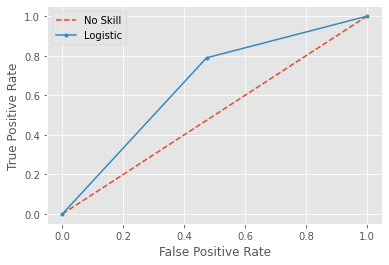

In [173]:
rf_probs_u = rf_fitted2.predict_proba(X_test_u)

# keep probabilities for the positive outcome only
rf_probs_u = rf_probs_u[:, 1]

# calculate scores
rf_auc = roc_auc_score(y_test_u, final_preds)
# roc curve for logistic regression model
# calculate roc curves
fpr, tpr, thresholds = roc_curve(y_test_u, final_preds)

# plot the roc curve for the model
pyplot.plot([0,1], [0,1], linestyle='--', label='No Skill')
pyplot.plot(fpr, tpr, marker='.', label='Logistic')

# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
pyplot.legend()

# show the plot
pyplot.show()

## Tuning Logistic Regression

In [185]:
lr_pipe_u = Pipeline([('scaler', StandardScaler()), ('classifier', LogisticRegression(max_iter=5000))])
lr_grid_params_u = {'classifier__penalty' : ['l2', 'elasticnet'], 'classifier__C' : np.logspace(-4, 4, 20),
                        'classifier__solver' : ['liblinear', 'saga']}
lr_grid_u = GridSearchCV(lr_pipe_u, lr_grid_params_u, cv=StratifiedKFold(10, shuffle=True), scoring = 'f1')
lr_fitted_u = lr_grid_u.fit(X_train_sub, y_train_sub)
print(f'Logistic Regression ROC-AUC training subset: { lr_grid.score(X_train_sub, y_train_sub)}')
print(f'Logistic Regression ROC-AUC test subset: { lr_grid.score(X_test_sub, y_test_sub)}')



/Users/carlahuebner/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:614: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/carlahuebner/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/carlahuebner/opt/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/Users/carlahuebner/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Users/carlahuebner/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py", line 451, in _check_solver
    " got solver={}.".format(solver))
ValueError

/Users/carlahuebner/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:614: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/carlahuebner/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/carlahuebner/opt/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/Users/carlahuebner/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py", line 1315, in fit
    " got (l1_ratio=%r)" % self.l1_ratio)
ValueError: l1_ratio must be between 0 and 1; got (l1_ratio=None)

  FitFailedWarning)
/Users/carlahuebner/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:614: FitFailedWa

/Users/carlahuebner/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:614: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/carlahuebner/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/carlahuebner/opt/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/Users/carlahuebner/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py", line 1315, in fit
    " got (l1_ratio=%r)" % self.l1_ratio)
ValueError: l1_ratio must be between 0 and 1; got (l1_ratio=None)

  FitFailedWarning)
/Users/carlahuebner/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:614: FitFailedWa

/Users/carlahuebner/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:614: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/carlahuebner/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/carlahuebner/opt/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/Users/carlahuebner/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Users/carlahuebner/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py", line 451, in _check_solver
    " got solver={}.".format(solver))
ValueError

/Users/carlahuebner/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:614: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/carlahuebner/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/carlahuebner/opt/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/Users/carlahuebner/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Users/carlahuebner/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py", line 451, in _check_solver
    " got solver={}.".format(solver))
ValueError

/Users/carlahuebner/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:614: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/carlahuebner/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/carlahuebner/opt/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/Users/carlahuebner/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py", line 1315, in fit
    " got (l1_ratio=%r)" % self.l1_ratio)
ValueError: l1_ratio must be between 0 and 1; got (l1_ratio=None)

  FitFailedWarning)
/Users/carlahuebner/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:614: FitFailedWa

/Users/carlahuebner/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:614: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/carlahuebner/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/carlahuebner/opt/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/Users/carlahuebner/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py", line 1315, in fit
    " got (l1_ratio=%r)" % self.l1_ratio)
ValueError: l1_ratio must be between 0 and 1; got (l1_ratio=None)

  FitFailedWarning)
/Users/carlahuebner/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:614: FitFailedWa

/Users/carlahuebner/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:614: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/carlahuebner/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/carlahuebner/opt/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/Users/carlahuebner/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py", line 1315, in fit
    " got (l1_ratio=%r)" % self.l1_ratio)
ValueError: l1_ratio must be between 0 and 1; got (l1_ratio=None)

  FitFailedWarning)
/Users/carlahuebner/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:614: FitFailedWa

/Users/carlahuebner/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:614: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/carlahuebner/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/carlahuebner/opt/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/Users/carlahuebner/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py", line 1315, in fit
    " got (l1_ratio=%r)" % self.l1_ratio)
ValueError: l1_ratio must be between 0 and 1; got (l1_ratio=None)

  FitFailedWarning)
/Users/carlahuebner/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:614: FitFailedWa

/Users/carlahuebner/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:614: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/carlahuebner/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/carlahuebner/opt/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/Users/carlahuebner/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py", line 1315, in fit
    " got (l1_ratio=%r)" % self.l1_ratio)
ValueError: l1_ratio must be between 0 and 1; got (l1_ratio=None)

  FitFailedWarning)
/Users/carlahuebner/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:614: FitFailedWa

/Users/carlahuebner/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:614: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/carlahuebner/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/carlahuebner/opt/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/Users/carlahuebner/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Users/carlahuebner/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py", line 451, in _check_solver
    " got solver={}.".format(solver))
ValueError

/Users/carlahuebner/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:614: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/carlahuebner/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/carlahuebner/opt/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/Users/carlahuebner/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py", line 1315, in fit
    " got (l1_ratio=%r)" % self.l1_ratio)
ValueError: l1_ratio must be between 0 and 1; got (l1_ratio=None)

  FitFailedWarning)
/Users/carlahuebner/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:614: FitFailedWa

/Users/carlahuebner/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:614: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/carlahuebner/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/carlahuebner/opt/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/Users/carlahuebner/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py", line 1315, in fit
    " got (l1_ratio=%r)" % self.l1_ratio)
ValueError: l1_ratio must be between 0 and 1; got (l1_ratio=None)

  FitFailedWarning)
/Users/carlahuebner/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:614: FitFailedWa

/Users/carlahuebner/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:614: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/carlahuebner/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/carlahuebner/opt/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/Users/carlahuebner/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Users/carlahuebner/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py", line 451, in _check_solver
    " got solver={}.".format(solver))
ValueError

/Users/carlahuebner/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:614: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/carlahuebner/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/carlahuebner/opt/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/Users/carlahuebner/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py", line 1315, in fit
    " got (l1_ratio=%r)" % self.l1_ratio)
ValueError: l1_ratio must be between 0 and 1; got (l1_ratio=None)

  FitFailedWarning)
/Users/carlahuebner/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:614: FitFailedWa

/Users/carlahuebner/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:614: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/carlahuebner/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/carlahuebner/opt/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/Users/carlahuebner/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py", line 1315, in fit
    " got (l1_ratio=%r)" % self.l1_ratio)
ValueError: l1_ratio must be between 0 and 1; got (l1_ratio=None)

  FitFailedWarning)
/Users/carlahuebner/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:614: FitFailedWa

/Users/carlahuebner/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:614: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/carlahuebner/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/carlahuebner/opt/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/Users/carlahuebner/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py", line 1315, in fit
    " got (l1_ratio=%r)" % self.l1_ratio)
ValueError: l1_ratio must be between 0 and 1; got (l1_ratio=None)

  FitFailedWarning)
/Users/carlahuebner/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:614: FitFailedWa

KeyboardInterrupt: 

# Stochastic Gradient Descent Classifier - ran almost instantaneously


In [207]:
sgd_pipe = Pipeline([('scaler', StandardScaler()), ('classifier', SGDClassifier())])
sgd_grid_params = {'classifier__alpha': [10.0**-np.arange(1,7)], 
                   'classifier__loss': ['hinge', 'modified_huber', 'squared_hinge', 'perceptron', 'squared_loss', 
                                            'huber', 'episilon_insensitive','squared_epsilon_insensitive','log'], 
                  'classifier__penalty': ['l2', 'l1', 'elasticnet']}
sgd_grid = GridSearchCV(sgd_pipe, sgd_grid_params, cv=StratifiedKFold(10, shuffle=True), scoring = 'f1')
sgd_fitted = sgd_grid.fit(X_train, y_train)
print("SGD Classifier: {}".format(sgd_pipe.score(X_train, y_train)))

print("SGD Classifier: {}".format(sgd_pipe.score(X_test, y_test)))


ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

In [206]:
sgd_fitted.best_params_

AttributeError: 'Pipeline' object has no attribute 'best_params_'

In [198]:
sgd_probs = sgd_fitted.predict_proba(X_test)

# Predictions with threshold from Profit Curve
final_preds_sgd = []
for i in sgd_probs[:,1]: 
    if i >=0.55: 
        final_preds_sgd.append(1)
    else: 
        final_preds_sgd.append(0)
        
# keep probabilities for the positive outcome only
sgd_probs = sgd_probs[:, 1]

# calculate scores
sgd_auc = roc_auc_score(y_test, final_preds_sgd)
# roc curve for logistic regression model
# calculate roc curves
fpr, tpr, thresholds = roc_curve(y_test_u, final_preds_sgd)

# plot the roc curve for the model
pyplot.plot([0,1], [0,1], linestyle='--', label='No Skill')
pyplot.plot(fpr, tpr, marker='.', label='Logistic')

# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
pyplot.legend()

# show the plot
pyplot.show()

AttributeError: probability estimates are not available for loss='hinge'

In [212]:
quicken_df.columns

Index(['census_tract', 'conforming_loan_limit', 'derived_dwelling_category',
       'derived_ethnicity', 'derived_race', 'derived_sex', 'action_taken',
       'loan_type', 'loan_amount', 'loan_to_value_ratio', 'loan_term',
       'property_value', 'construction_method', 'occupancy_type',
       'total_units', 'income', 'debt_to_income_ratio',
       'applicant_credit_score_type', 'applicant_ethnicity_observed',
       'applicant_race_observed', 'applicant_age', 'aus-1'],
      dtype='object')

In [213]:
quicken_df['derived_race'].value_counts()

White                                        81852
Race Not Available                           40618
Black or African American                     8189
Asian                                         5991
Joint                                         1828
American Indian or Alaska Native               651
Native Hawaiian or Other Pacific Islander      236
2 or more minority races                       168
Name: derived_race, dtype: int64

In [215]:
600/81852*100

0.7330303474563847